In [1]:
import nbimporter
from breakthrough_game_code_and_agents import *
from my_robot_functions_JF import *
from classy import *
from pylab import imread,imsave,imshow
from image_defs import *


Version:  0.3.09
Version  1.0.7
Version:  0.0.49


In [2]:
BP=None     # REMOVE WHEN RUNNING ON ROBOT

if BP is None:
    print("Running on the laptop.")
    on_laptop=True
else:
    print("Running on the robot.")
    on_laptop=False


Running on the laptop.


# Agent

In [3]:
def read_state_from_file(filename):
    text = open(filename).read()
    text = text.strip()
    lines = [line.strip() for line in text.split('\n')]  # get rid of \n
    
    row = lines[0].split()
    R, C = len(lines), len(row)
    print(f"{R}x{C} board")
    state = Board(R, C)
    state.board = [int(val) for val in text.split()]
    print(state)
    return state


In [4]:
def get_move(state,player):
    if player==2:
        Q=SmallTable("small_breakthrough_skittles2.json")
    else:
        Q=SmallTable("small_breakthrough_skittles1.json")

    if state not in Q:
        print("State not in the table: ",state)
        move=random_move(state,player)
    else:
        move=top_choice(Q[state])

    return move

read_state=read_state_from_file


# Make Move

In [5]:
def make_move(state,player,move):
    start,end=move
    row,col=state.row(start),state.col(start)

    # depends on where the robot starts
    number_cols_to_move=1+col
    number_rows_to_move=5-row


    go_forward_squares_yellow(number_cols_to_move)
    rot90()
    forward1()
    go_forward_squares_blue(number_rows_to_move)

    #  0  1  2  3  4
    #  5  6  7  8  9
    # 10 11 12 13 14
    # 15 16 17 18 19
    # 20 21 22 23 24
    
    if start-end==4:
        diagonal_right()
    elif start-end==6:
        diagonal_left()
    elif start-end==5:
        print('Reverse off board')
        off_board()
    else:
        raise ValueError("You can't get there from here")

    print("Making move ",move)


In [6]:
import ijson   # install with pip install ijson on both laptop and robot
from Game.tables import make_immutable,str2table


In [7]:
class SmallTable(object):

    def __init__(self,filename):
        self.filename=filename

    def __getitem__(self, key):
        key=make_immutable(key)
        with open(self.filename, "rb") as f:
            for record in ijson.items(f, str(key)):
                return str2table(record)

        raise KeyError

    def __contains__(self, key):
        keyi=make_immutable(key)
        try:
            value=self[keyi]
            return True
        except KeyError:
            print(key)
            print(keyi.__repr__())
            return False


# Read State

In [8]:
def read_state():
    from pylab import imread,imsave
    from numpy import atleast_2d
    import os
    from numpy import atleast_2d
    import cv2

    if not os.path.exists("predicted"):
        os.mkdir("predicted")
    
    state=Board(5,5)      #<========= change the size
    nr,nc=state.shape

    
    corners=array([
    [ 317.,  65.],        # These are the specific corners that my images are inside
    [1235.,  45.],        # This was done because I was running into issues with thresholding the image
    [1290.,  735.],
    [ 298.,  755.]],dtype=np.float32)
    
    # load the classifier
    classifier=CSC()
    classifier.load('CSC_trained_JF.json')
    
    
    # get the picture
    filename='current_board.jpg'              # for the robot
    take_picture(filename)


    # this part comes from your Make Training Squares script
    image=imread(filename)

    # these 5 lines are specific to your image
    image=image[:,:,:]
    im3=straighten_image(image,corners)
    sqr=125
    sqc=160
    buf_c=45
    init_buf_r=55
    count=0
    squares=[]
    values=[]
    for r in range(nr):
        for c in range(nc):
            start_im_c=c*sqc+c*buf_c
            end_im_c=start_im_c+sqc
            
            start_im_r=r*sqr+init_buf_r
            end_im_r=start_im_r+sqr

            im_square=image[start_im_r:end_im_r,start_im_c:end_im_c]

            # extract the middle 70x70

            #sq_sz=80
            #sz=im_square.shape
            #start_r=sz[0]//2-sq_sz//2
            #start_c=sz[1]//2-sq_sz//2
            #im_square=im_square[start_r:start_r+sq_sz,start_c:start_c+sq_sz]


            squares.append(im_square)
            
            
            # convert the square image to a data vector for the classifier
            resized_square = cv2.resize(squares[count], (80, 80))  # ChatGPT was used for these 2 lines of code because the vector it
                                                                   # the function returned was not the same size as my images (80,80,3)
            vector = resized_square.ravel()
            prediction=classifier.predict(atleast_2d(vector))[0]
        
            values.append(prediction)
    
            # for debugging
            imsave('predicted/square %d predicted as piece %d.jpg' % (count,prediction),squares[count])
        
            count+=1
            
            
    squares=get_board_squares_from_image(im3,state.shape)


    #count=0
    #for r in range(nr):
        #for c in range(nc):
            

    
    # reconstruct the state from the predictions
    state.board=values

    print("Current state is:")
    print(state)

    x=input("""
    Hit return if this is correct, otherwise type a character 
    and the state will be read from board-JF.txt.""")

    if x:
        print("Reading from file...")
        state=read_state_from_file('board-JF.txt')

    print("Using")
    print(state)

    
    return state

In [9]:
classifier=CSC()
classifier.load('CSC_trained_JF.json')

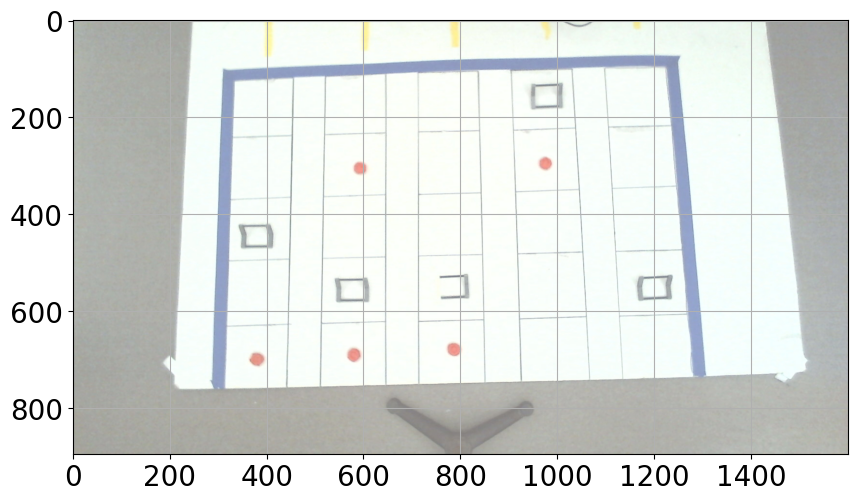

In [10]:
if on_laptop:
    image=imread("current_board.jpg")
    imshow(image)

In [11]:
if on_laptop:
    state=read_state()

(REMOVE THIS FUNCTION FROM my_robot_functions IF YOU'RE ON THE ROBOT
    --- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Setting Brightness to 255 (100%).
Adjusting resolution from 1600x900 to 1600x896.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to 'current_board.jpg'.
    
Current state is:
 2  2  2  2  2 
 2  2  0  0  0 
 2  2  0  0  0 
 2  2  0  0  0 
 2  1  0  0  0 




    Hit return if this is correct, otherwise type a character 
    and the state will be read from board-JF.txt. j


Reading from file...
5x5 board
 1  1  1  0  1 
 0  0  0  1  0 
 0  0  0  0  0 
 0  0  0  0  0 
 2  2  2  2  2 

Using
 1  1  1  0  1 
 0  0  0  1  0 
 0  0  0  0  0 
 0  0  0  0  0 
 2  2  2  2  2 



In [12]:
player=2 # or player=2 depending on which you want
state=read_state() # read the pieces, and construct the state
move=get_move(state,player) # replace with minimax,skitles, Q, etc...
make_move(state,player,move) # actually move the pieces

(REMOVE THIS FUNCTION FROM my_robot_functions IF YOU'RE ON THE ROBOT
    --- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Setting Brightness to 255 (100%).
Adjusting resolution from 1600x900 to 1600x896.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to 'current_board.jpg'.
    
Current state is:
 2  2  2  2  2 
 2  0  0  0  0 
 2  0  0  0  0 
 0  0  0  0  2 
 2  0  0  0  0 




    Hit return if this is correct, otherwise type a character 
    and the state will be read from board-JF.txt. l


Reading from file...
5x5 board
 1  1  1  0  1 
 0  0  0  1  0 
 0  0  0  0  0 
 0  0  0  0  0 
 2  2  2  2  2 

Using
 1  1  1  0  1 
 0  0  0  1  0 
 0  0  0  0  0 
 0  0  0  0  0 
 2  2  2  2  2 

Yellow function started
Starting forward movement
Rotate 90 started
forward for 1 second
Blue function started
Starting forward movement
Reverse off board
moving off board
Making move  [24, 19]
